In [1]:
# pip install pandas numpy scikit-learn matplotlib yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from graphing import graph_normal, show_results, graph_line
from results import get_num_correct_direction_difference
from get_data import get_apple_stock_split , get_recent_apple_stock_split

In [3]:
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

DAYS_LAG = 20

X_train, X_test, y_train, y_test = get_apple_stock_split(DAYS_LAG)

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_Y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test = scaler_Y.transform(y_test)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Training samples: 1772, Testing samples: 444


In [4]:
print(np.mean(y_test))
print(np.std(y_test, ddof=1))

print(np.mean(y_train))
print(np.std(y_train, ddof=1))

-0.05611568145895159
0.15609252474669716
-0.0709070732830667
0.14851876290947447


<h1> GridSearch setup </h1>

In [5]:
#Define the different hyperparameters for a support vector machine
# param_grid = {
#     'kernel': ['linear', 'rbf'],           # The method for transforming the data into anthor dimension so the SVM can find a hyperplane 
#     'C': [0.1, 1],                # Paramter for penalizing misclassifications - effects under or over fitting
#     'gamma': ['auto'],            # Controlls weight of each point, lower gamma - smoother decision boundary, more generalised
#     'epsilon': [0.01, 0.1],               # Defines the margin where predictions are considered correct.
#     'degree': [2]                          # Degee of polynomial
# }



param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],   # The method for transforming the data into anthor dimension so the SVM can find a hyperplane 
    'C': [0.1, 1, 10, 100],                # Paramter for penalizing misclassifications - effects under or over fitting
    'gamma': ['scale', 'auto'],            # Controlls weight of each point, lower gamma - smoother decision boundary, more generalised
    'epsilon': [0.01, 0.1, 0.5, 1],        # Defines the margin where predictions are considered correct.
    'degree': [2, 3 , 4]                   # Degee of polynomial
}

In [6]:
#training
svr = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=3,                                      # Cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=100,                               # How Much is printed in Console
    n_jobs=-1                                  # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train.ravel())

results_df = pd.DataFrame(grid_search.cv_results_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV 1/3; 1/288] START C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear.
[CV 1/3; 1/288] END C=0.1, degree=2, epsilon=0.01, gamma=scale, kernel=linear;, score=-0.082 total time=   0.1s
[CV 1/3; 5/288] START C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf.....
[CV 1/3; 5/288] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf;, score=-0.081 total time=   0.1s
[CV 3/3; 5/288] START C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf.....
[CV 3/3; 5/288] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=rbf;, score=-0.087 total time=   0.1s
[CV 3/3; 6/288] START C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=poly....
[CV 3/3; 6/288] END C=0.1, degree=2, epsilon=0.01, gamma=auto, kernel=poly;, score=-0.088 total time=   0.1s
[CV 3/3; 8/288] START C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf.....
[CV 3/3; 8/288] END C=0.1, degree=2, epsilon=0.1, gamma=scale, kernel=rbf;, score=-0.089 total 

In [7]:
show_results(grid_search.cv_results_)

Rank 1:
Parameters: {'C': 0.1, 'degree': 3, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Mean Test Score: -0.0841
Std Dev of Test Score: 0.0027
------------------------------
Rank 2:
Parameters: {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Mean Test Score: -0.0842
Std Dev of Test Score: 0.0027
------------------------------
Rank 3:
Parameters: {'C': 1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Mean Test Score: -0.0842
Std Dev of Test Score: 0.0027
------------------------------
Rank 4:
Parameters: {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Mean Test Score: -0.0842
Std Dev of Test Score: 0.0028
------------------------------
Rank 5:
Parameters: {'C': 1, 'degree': 3, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Mean Test Score: -0.0843
Std Dev of Test Score: 0.0026
------------------------------
Rank 6:
Parameters: {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}

In [8]:
# use best model to predict test data
final_model = grid_search.best_estimator_

# Predict on test data
predictions = scaler_Y.inverse_transform(final_model.predict(X_test).reshape(-1,1))
actual = scaler_Y.inverse_transform(y_test)

mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)

print(f"Final Model RMSE: {rmse}")
print(f"Final Model MAE: {mae}")

Final Model RMSE: 1.727885782917047
Final Model MAE: 0.9605725761681454


[*********************100%***********************]  1 of 1 completed

RMSE: 3.0835878305423785
MAE: 2.3167553921000112


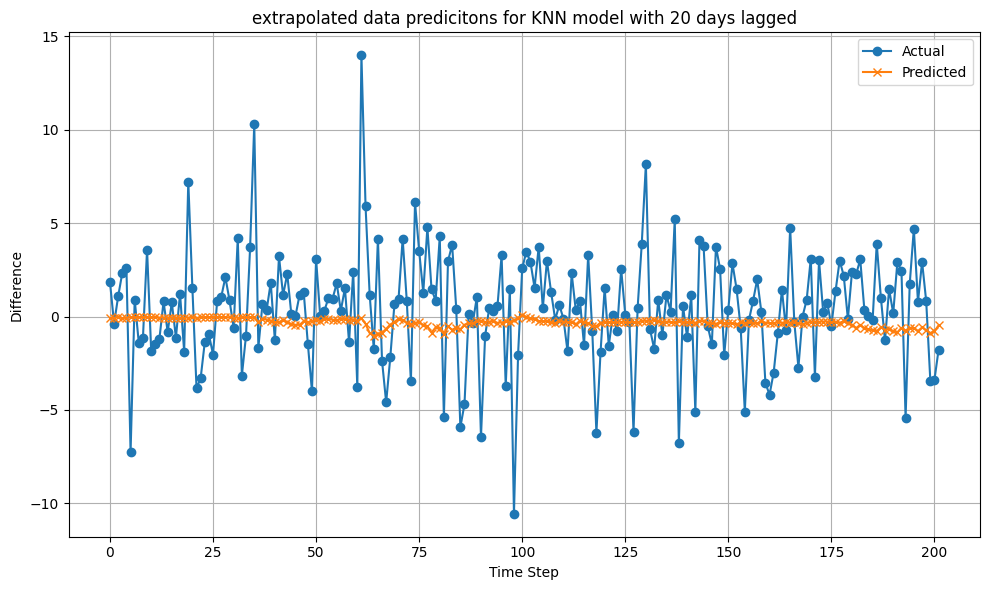

Price   Ticker
Target            78
dtype: int64 correct directions out of a total: 202


/mnt/c/Users/kenan/dev/university_final_year_project/venv_linux/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Price   Ticker
Target            78
dtype: int64

In [9]:
# trying to predict more recent ones
X, y = get_recent_apple_stock_split(DAYS_LAG)

X_scaled = scaler_X.transform(X)
predictions = scaler_Y.inverse_transform(grid_search.best_estimator_.predict(X_scaled).reshape(-1,1))

mae = mean_absolute_error(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
#graph_normal(predictions, y, "recent data predicitons")
graph_line(predictions, y, f"extrapolated data predicitons for KNN model with {DAYS_LAG} days lagged")
get_num_correct_direction_difference(predictions,y)